# Algorithmic Trading | Backtesting of 3 strategies

#### install required packages

In [19]:
# !pip install ta

#### import all required packages

In [24]:
import numpy as np
import ta
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

## Strategy 1: Swing Trading Strategy

### Key Indicators:
- Exponential moving averages

As a short-term EMA(8), medium-term EMA(14), and long-term EMA(50).The strategy will look for a "bullish crossover" by checking if the shorter-term EMAs are above the longer-term EMAs. Bullish crossover could indicate of potential upward momentum in the price
- Stochastic indicators: %K (stoch_k) and %D (stoch_d)

The Stochastic RSI measures the current RSI value relative to its high-low range over a specified period. It consists of two components: the K value and the D value. In this strategy, we pay close attention to the relationship between the K and D values. When the K value crosses above the D value, it generates a potential buying signal. This crossover indicates that the short-term momentum of the asset is gaining strength and is likely to continue its upward movement.
- Average true range as a volatility indicator

Average True Range (ATR) measures market volatility, providing us with an understanding of how much an asset's price typically moves within a given time frame. It helps set appropriate stop-loss and take-profit levels based on the asset's volatility.

### Implementing buy/sell
Rules to Buy, when all following conditions are met:
1. Increasing volume;
2. Stoch K value cross above Stoch D;
3. EMA(8) > EMA(14) > EMA(50);

Rules to Sell, when one of following conditions are met:
1. tp: the current price of the asset is at least three times the value of the Average True Range (ATR) above the entry price
2. sl: the current price of the asset is at least four times the value of the Average True Range (ATR) lower the entry price

### Back-testing
Before implementing the strategy, we'll conduct rigorous back-testing using historical data to assess its performance. The historical data was obtained from deribit.com and covers the time period from July 4th, 2023, at 7:00 AM to July 7th, 2023, at 7:00 PM.

Total Return: -7.38%


C:\Users\Olga\AppData\Local\Temp\ipykernel_6904\3743732801.py:93: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  axs[0] = plt.subplot(gs[0])
C:\Users\Olga\AppData\Local\Temp\ipykernel_6904\3743732801.py:106: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  axs[1] = plt.subplot(gs[1], sharex=axs[0])


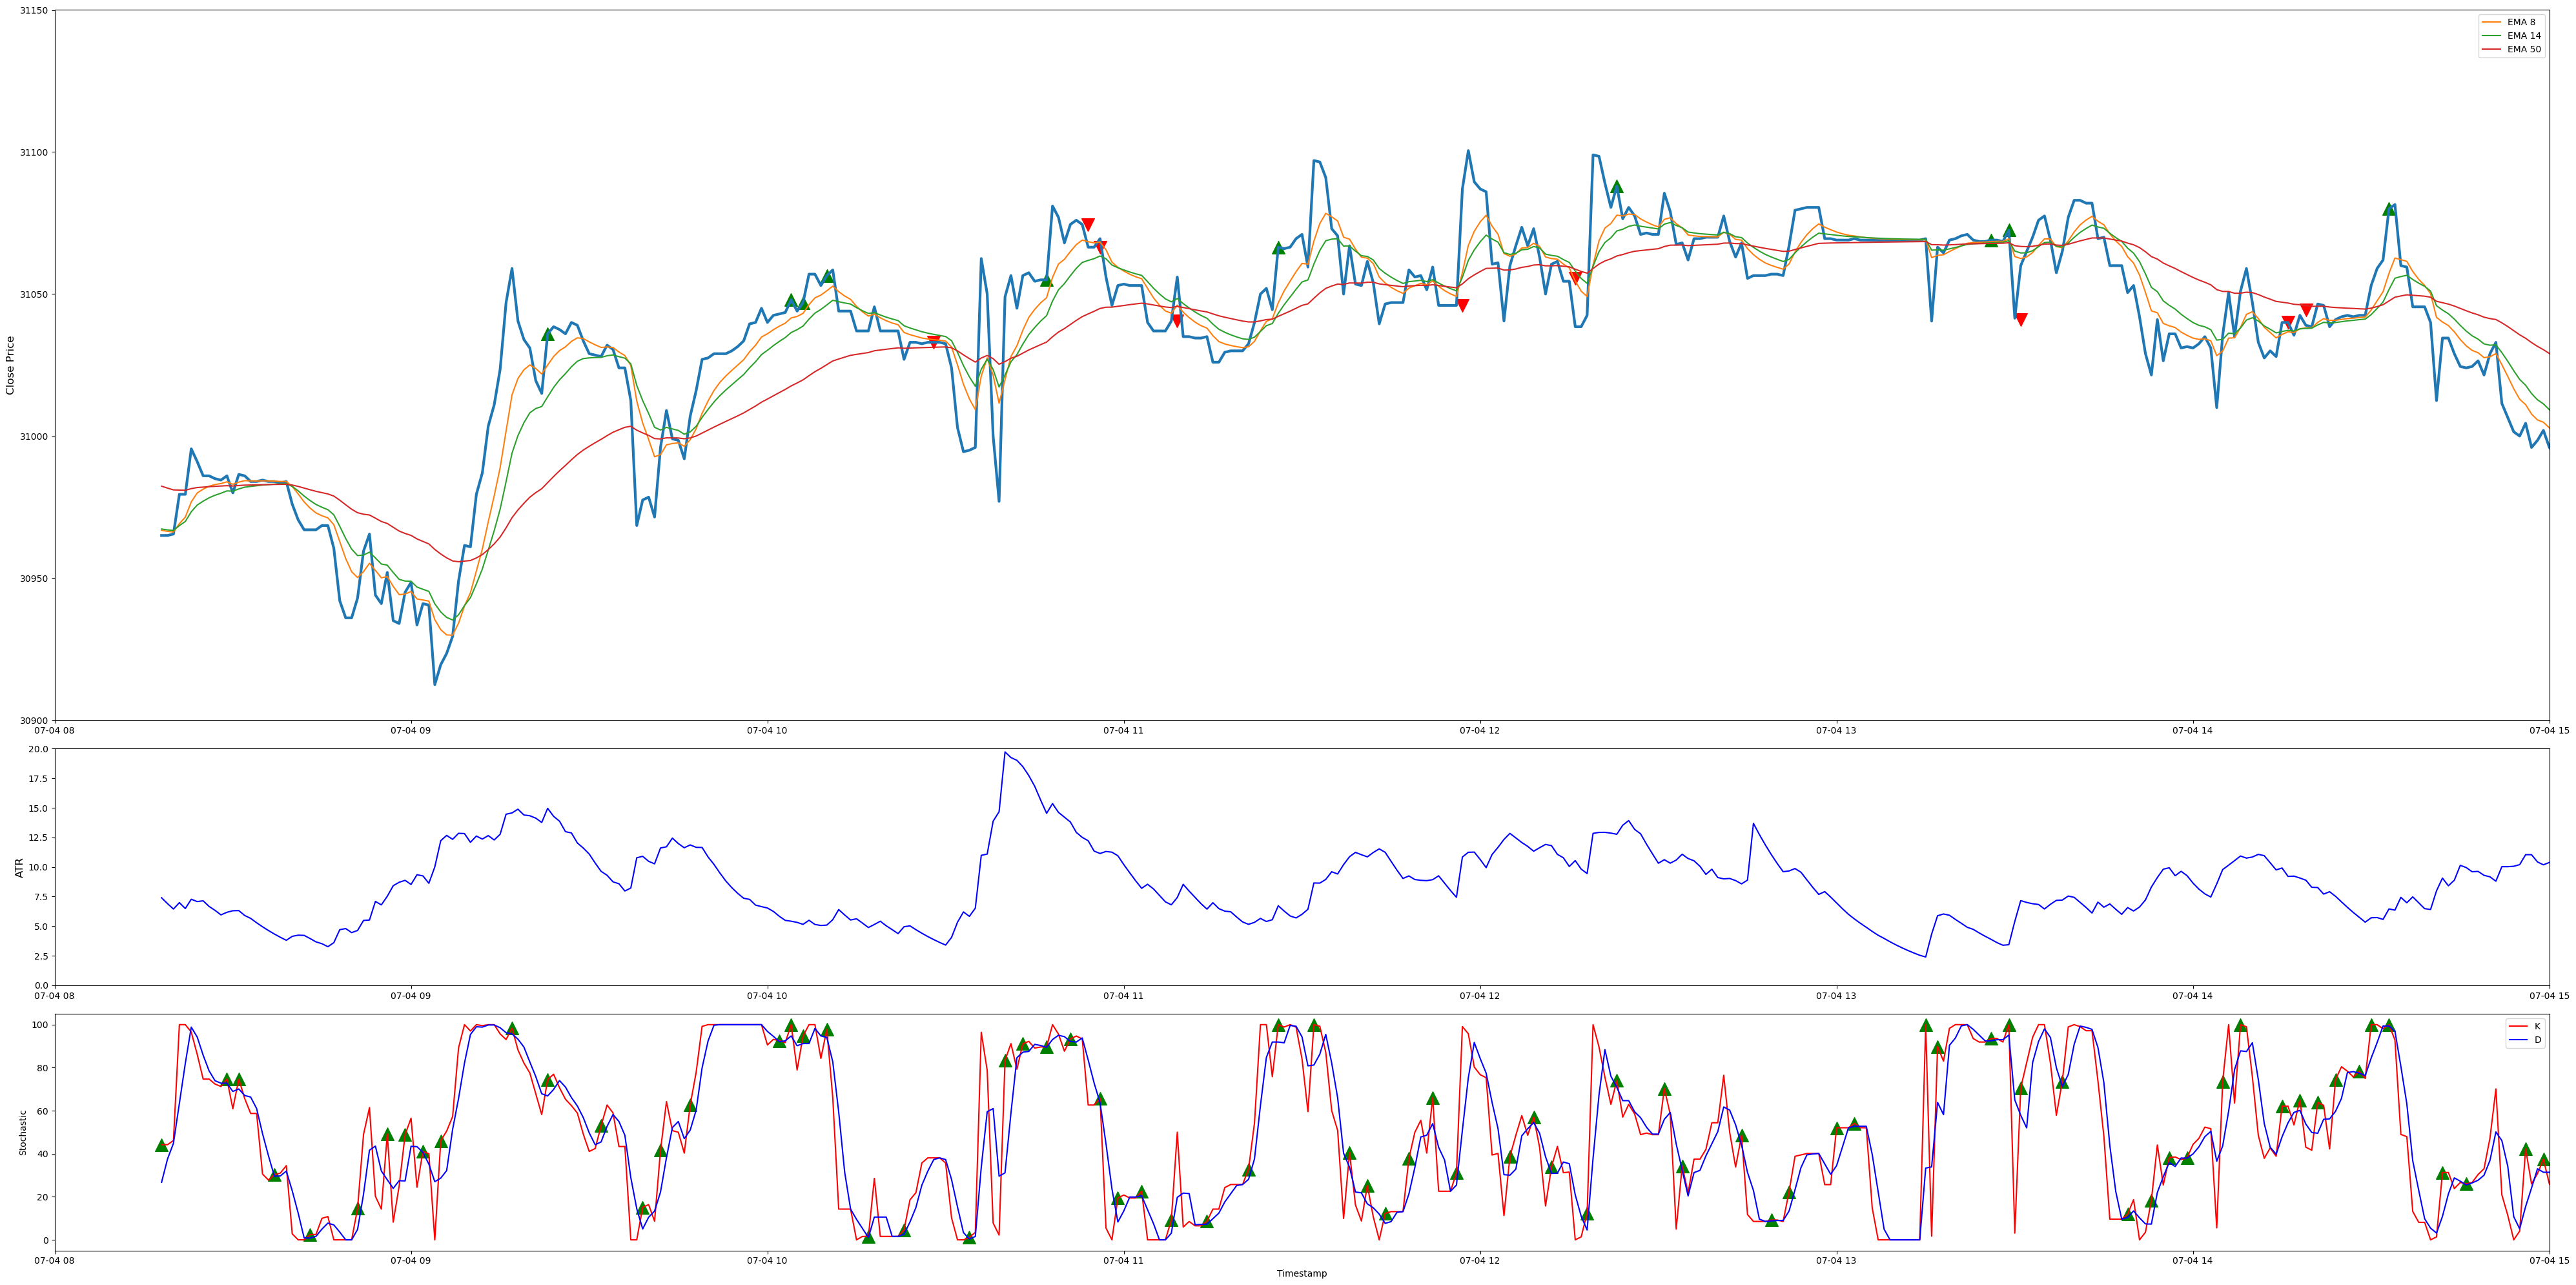

In [25]:
class MyBacktest:
    def strategy(self):
        ohlc = pd.read_csv('ohlc_data.csv')
        # Stochastic indicators
        ohlc['stoch_k'] = ta.momentum.stoch(ohlc.high, ohlc.low, ohlc.close,window=14,smooth_window=3)
        ohlc['stoch_d'] = ohlc['stoch_k'].rolling(3).mean()
        # exponential moving averages: 8,14 and 50
        for i in (8, 14, 50):
            ohlc['ema_' + str(i)] = ta.trend.ema_indicator(ohlc.close, window=i)
        # average true range(ATR)
        ohlc['atr'] = ta.volatility.average_true_range(ohlc.high, ohlc.low, ohlc.close)
        #looking for a "bullish crossover"
        def checkcross(ohlc):
            return (ohlc['stoch_k'] > ohlc['stoch_d']) & \
                (ohlc['stoch_k'] > ohlc['stoch_d']).diff()
        ohlc['cross'] = checkcross(ohlc)
        #sellsignal when the priced incresed 3 times ATR, or decreased 4 times ATR
        ohlc.dropna(inplace=True)
        ohlc['tp'] = ohlc.close + (ohlc.atr * 3)
        ohlc['sl'] = ohlc.close - (ohlc.atr * 4)
        volume_confirmation = ohlc.volume > ohlc.volume.shift()
        #buysignal when there is a cross and  when the shorter-term moving averages are above the longer-term moving averages, suggesting a bullish trend in the market
        ohlc['buysignal'] = np.where( (volume_confirmation) &
                                      (ohlc.cross) &
                                      (ohlc.close > ohlc.ema_8) &
                                      (ohlc.ema_8 > ohlc.ema_14) &
                                      (ohlc.ema_14 > ohlc.ema_50), 1, 0)

        buydates, buyprices = [], []
        selldates, sellprices = [], []
        sell_reason = []
        in_position = False

        for i, row in ohlc.iterrows():
            if row['buysignal'] == 1 and not in_position:
                buyprice = row['close']
                buydate = row['timestamp']
                buydates.append(buydate)
                buyprices.append(buyprice)
                in_position = True
                k = 1

            if in_position and i + k < len(ohlc):
                if ohlc.high.iloc[i + k] >= row['tp']:
                    selldate = ohlc.iloc[i + k]['timestamp']
                    selldates.append(selldate)
                    sell_reason.append('tp')
                    sellprice = ohlc.iloc[i + k]['open']
                    sellprices.append(sellprice)
                    in_position = False
                elif ohlc.low.iloc[i + k] <= row['sl']:
                    selldate = ohlc.iloc[i + k]['timestamp']
                    selldates.append(selldate)
                    sell_reason.append('sl')
                    sellprice=ohlc.iloc[i + k]['open']
                    sellprices.append(sellprice)
                    in_position = False
                    k += 1

        selldate_indices = [ohlc.index[ohlc['timestamp'] == selldate].tolist()[0] for selldate in selldates]
        ohlc.loc[selldate_indices, 'sellsignal'] = 1
        ohlc.loc[selldate_indices, 'sell_reason'] = sell_reason
        ohlc.sellsignal = ohlc.sellsignal.fillna(0).astype(int)

        # Create DataFrame for trade results
        trades_df = pd.DataFrame({
            'buy_date': buydates,
            'buy_price': buyprices,
            'sell_date': selldates[:len(buydates)],
            'sell_price': sellprices[:len(buydates)],
            'sell_reason': sell_reason[:len(buydates)]
        })
        trades_df = trades_df[:len(buydates)]
        # Calculate trade returns
        trades_df['return'] = (trades_df['sell_price'] / trades_df['buy_price']) - 1
        total_return = (trades_df['return'] + 1).prod() - 1
        # Calculate total return
        total_return = 1.0
        for buy_price, sell_price in zip(buyprices, sellprices):
            total_return *= (sell_price / buy_price)
        total_return -= 1.0
        # Print trade results
        print(f"Total Return: {total_return:.2%}")
        ohlc.to_csv('strategy_results.csv', index=False)

        # Plotting
        ohlc['timestamp'] = pd.to_datetime(ohlc['timestamp'])
        fig, axs = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(40, 20))
        gs = gridspec.GridSpec(3, 1, height_ratios=[3, 1, 1])
        # Candlestick chart
        axs[0] = plt.subplot(gs[0])
        axs[0].plot(ohlc['timestamp'], ohlc['close'], linewidth=3)
        axs[0].scatter(buydates, buyprices, marker='^', color='g', s=200)
        axs[0].scatter(selldates, sellprices, marker='v', color='r', s=200)
        axs[0].set_ylabel('Close Price', fontsize='large')
        axs[0].set_ylim(30900, 31150)
        axs[0].set_xlim(pd.Timestamp('2023-07-04 08:00:00'), pd.Timestamp('2023-07-04 15:00:00'))
                # EMA lines
        for i in (8, 14, 50):
            axs[0].plot(ohlc['timestamp'], ohlc['ema_' + str(i)], label='EMA ' + str(i), linewidth=1.5)
        axs[0].legend()

        # ATR
        axs[1] = plt.subplot(gs[1], sharex=axs[0])
        axs[1].plot(ohlc['timestamp'], ohlc['atr'], color='blue')
        axs[1].set_ylabel('ATR', fontsize='large')
        axs[1].set_xlim(pd.Timestamp('2023-07-04 08:00:00'), pd.Timestamp('2023-07-04 15:00:00'))
        axs[1].set_ylim(0, 20)
        # Stochastic K and D
        axs[2] = plt.subplot(gs[2], sharex=axs[0])
        axs[2].plot(ohlc['timestamp'], ohlc['stoch_k'], color='red', label='K', linewidth=1.5)
        axs[2].plot(ohlc['timestamp'], ohlc['stoch_d'], color='blue', label='D')
        axs[2].scatter(ohlc[ohlc['cross'] == 1]['timestamp'], ohlc[ohlc['cross'] == 1]['stoch_k'], marker='^', color='g', s=200)
        axs[2].set_ylabel('Stochastic')
        axs[2].legend()
        axs[2].set_xlim(pd.Timestamp('2023-07-04 08:00:00'), pd.Timestamp('2023-07-04 15:00:00'))


        # Set x-axis label as timestamp
        axs[-1].set_xlabel('Timestamp')

        plt.tight_layout()
        plt.show()

backtest = MyBacktest()
backtest.strategy()

In [ ]:
Result:
    The analysis reveals that the overall result indicates a loss of 7.38%. One significant observation is that our second buying condition, which involves the Stochastic RSI K value crossing above the Stochastic RSI D value, proves to be effective in predicting further price increases. However, this buying signal was not frequently triggered due to the requirement of the first condition, which demands that the current price is higher than EMA(8), EMA(14), and EMA(50). As a result, when both conditions were met, the price was often at or near its peak.
Moreover, the selling condition, which is based on a stop loss value set at 4 ATR distance from the entry price, tends to be triggered relatively quickly. This leads to a situation where most of the orders end up selling the previously bought bitcoins at a lower price. In such cases, the potential for profit is highly dependent on the likelihood of reaching the take profit value, especially when volatility in the market is high.
    Conducting a backtest yields following suggetions for strategy improvements:

1. Currently the sell signal is triggered by static stop loss and take profit values.
First suggetion would be to replace static sl and tp with dynamic ones based on market volatility and adgust parameters 
2. Secondly, implement dynamic position sizing based on factors like account equity or volatility. Now it is fixed. 

Although, the backtest shows a negative return, I believe this strategy may bring positive outcome, following mentioned suggetions.
The biggest advantage of this stratagy is incorporating 2 different trend indicators, which helps to make better decisions. 
This could help avoid losses during choppy markets.


In [ ]:
## Strategy 2: Simple Moving Average crossover

This strategy is straightforward: it looks for a crossover between short and long moving averages.
The buy signal is triggered when short-term prices rise above long-term ones and sell when the opposite occurs.

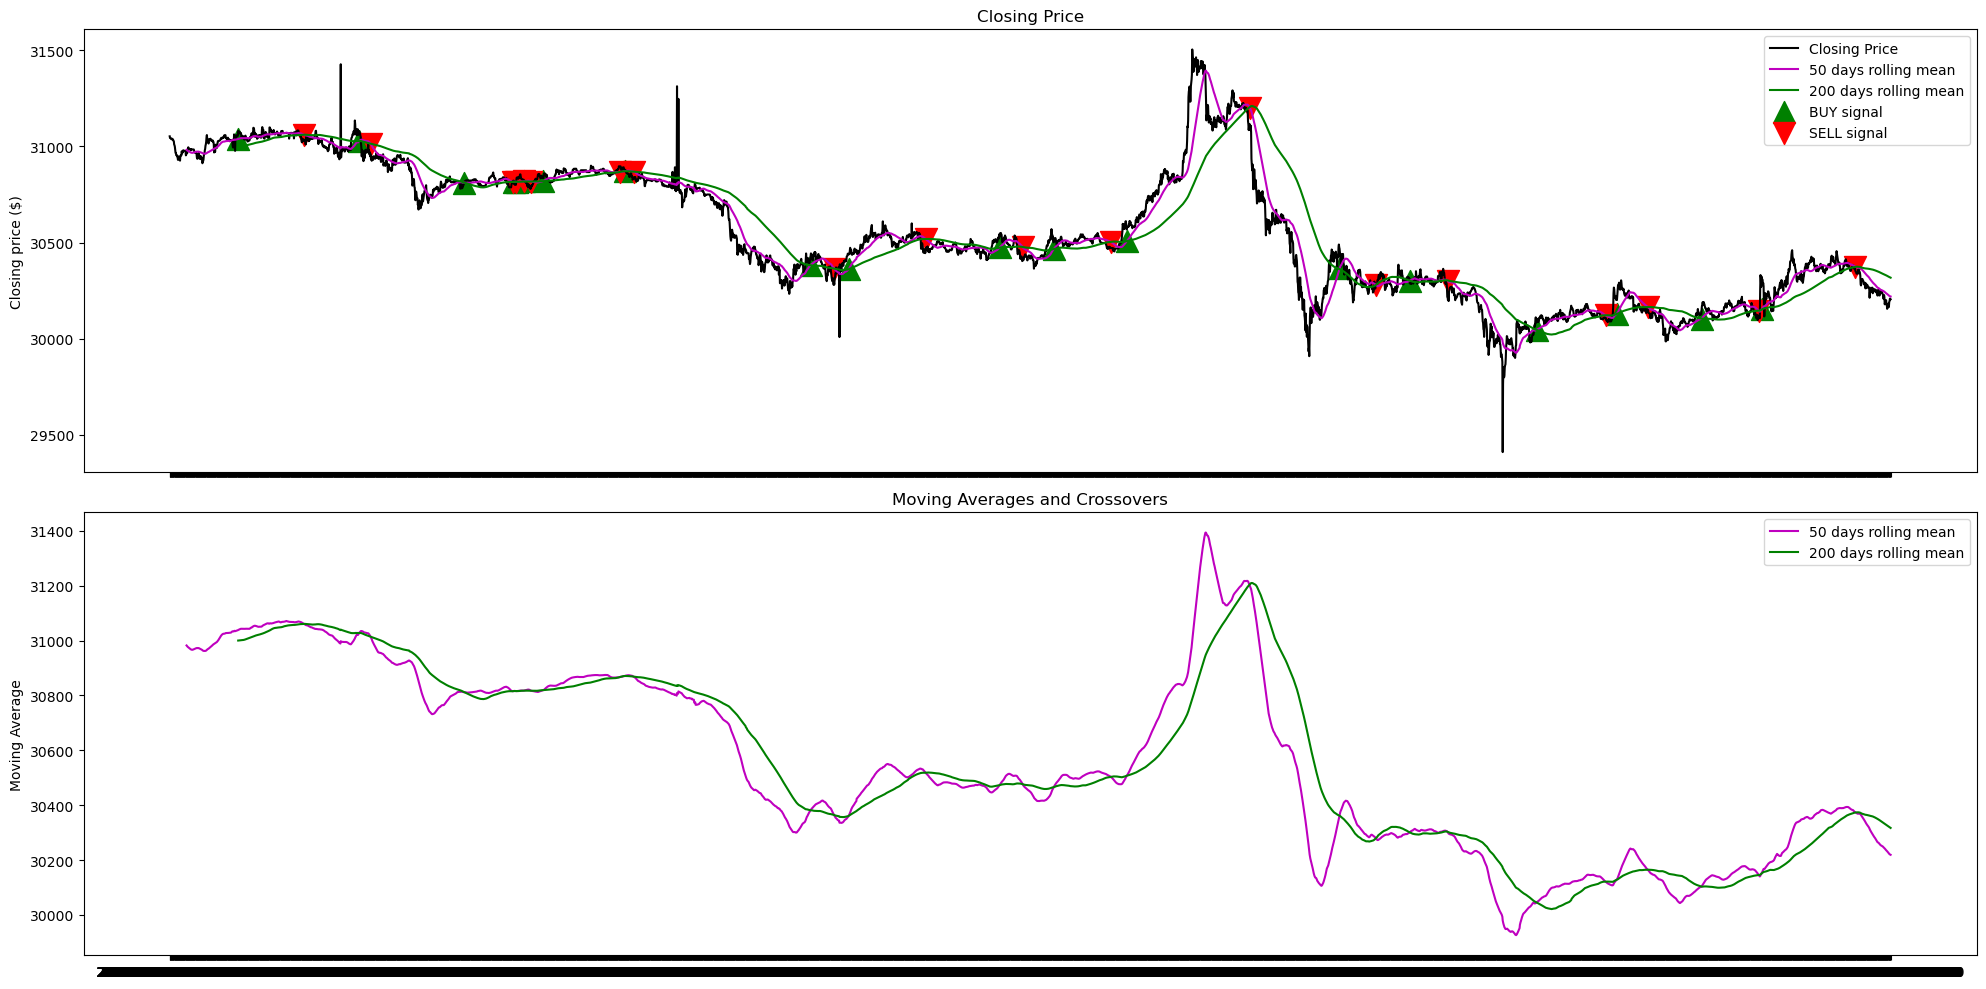

SMA Crossover Return: 101.62%


In [22]:
ohlc = pd.read_csv('ohlc_data.csv')

# Calculate log returns
ohlc['log_return'] = np.log(ohlc['close']).diff()

# Calculate SMA crossover strategy
short_window = 50
long_window = 200
ohlc['short_ma'] = ohlc['close'].rolling(window=short_window).mean()
ohlc['long_ma'] = ohlc['close'].rolling(window=long_window).mean()
# short-term moving average crosses above the long-term moving average
ohlc['sma_signal'] = np.where(ohlc['short_ma'] > ohlc['long_ma'], 1, 0)
#identify the points of crossover
ohlc['sma_position'] = ohlc['sma_signal'].diff()
# buy if ma(50) is higher than ma(200), or sell if smaller.
# In my case 1 stays for buying, -1 is for selling
ohlc['sma_trade'] = np.where(ohlc['short_ma'] > ohlc['long_ma'], 1, -1)
# calculate return for each trade
ohlc['sma_strategy_return'] = ohlc['log_return'] * ohlc['sma_trade']

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 10), sharex=True)

# Plot closing price
ax1.plot(ohlc['timestamp'], ohlc['close'], color='k', label='Closing Price')
# Plot 50-day rolling mean
ax1.plot(ohlc['timestamp'], ohlc['short_ma'], color='m', label='50 days rolling mean')

# Plot 200-day rolling mean
ax1.plot(ohlc['timestamp'], ohlc['long_ma'], color='g', label='200 days rolling mean')

# Plot ‘buy’ signals
ax1.scatter(ohlc.loc[ohlc['sma_position'] == 1, 'timestamp'],
            ohlc.loc[ohlc['sma_position'] == 1, 'short_ma'],
            marker='^', s=250, color='g', label='BUY signal')

# Plot ‘sell’ signals
ax1.scatter(ohlc.loc[ohlc['sma_position'] == -1, 'timestamp'],
            ohlc.loc[ohlc['sma_position'] == -1, 'short_ma'],
            marker='v', s=250, color='r', label='SELL signal')

ax2.plot(ohlc['timestamp'], ohlc['short_ma'], color='m', label='50 days rolling mean')

# Plot 200-day rolling mean
ax2.plot(ohlc['timestamp'], ohlc['long_ma'], color='g', label='200 days rolling mean')

# Set titles and labels
ax1.set_title('Closing Price')
ax1.set_ylabel('Closing price ($)')

ax2.set_title('Moving Averages and Crossovers')
ax2.set_ylabel('Moving Average')

# Add legends
ax1.legend()
ax2.legend()

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

# Calculate returns
sma_crossover_return = np.exp(ohlc['sma_strategy_return'].sum())
print("SMA Crossover Return: {:.2%}".format(sma_crossover_return))

In [ ]:
Result:
For second strategy the overall result indicates a win of 1.62%. 
We may observe that the buy signal happens indeed at relatively low prices, then selling occurs with some increase in price, but the sell signal was not triggered in 3 out of 4 main peaks.
I believe in some cases selling happens too early after buying, maybe it would make sence to wait some time and sell it at peak.
However, this observation indicates the strategy is safe, as high market volatility is avoided
The general suggetion would be to review the parameters and add additional indicator

In [ ]:
## Strategy 3: High/Low rolling Strategy

### Implementing buy/sell

'roll_high' = ohlc['high'].rolling(10).max()
'roll_low' = ohlc['low'].rolling(10).min()
'mid' = (ohlc['roll_high'] + ohlc['roll_low']) / 2

Buy condition:
Close > mid line after the cross

Sell condition:
Close ~ rolling max high with 4% difference

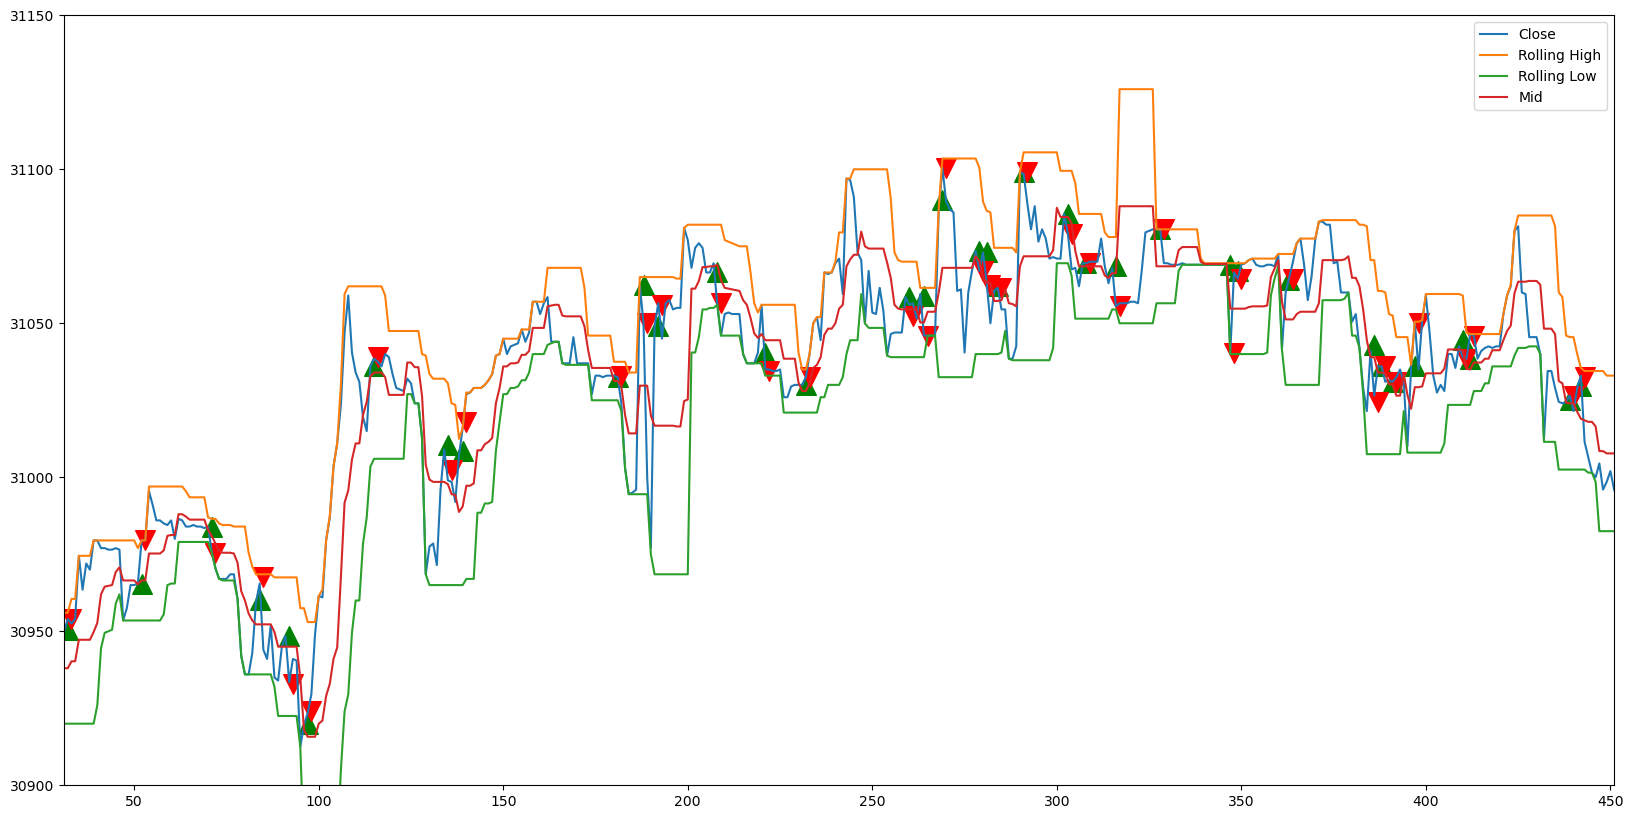

In [23]:
ohlc = pd.read_csv('ohlc_data.csv')
# maximum value over the last 10 min
ohlc['roll_high'] = ohlc['high'].rolling(10).max()
# minimum value over the last 10 min
ohlc['roll_low'] = ohlc['low'].rolling(10).min()
# find average between them
ohlc['mid'] = (ohlc['roll_high'] + ohlc['roll_low']) / 2
# define when to buy: close price should be at least 4% lower than highest value
ohlc['high_approach'] = np.where(ohlc['close'] > ohlc['roll_high'] * 0.996, 1, 0)
# define when to sell: close price should higher than middle and cross it
ohlc['close_mid'] = np.where(ohlc['close'] > ohlc['mid'], 1, 0)
ohlc['midcross'] = ohlc['close_mid'].diff() == 1

buy_date = []
sell_date = []
buy_price = []
sell_price = []

flag = False

for i in range(len(ohlc)-1):
    if not flag and ohlc.iloc[i]['midcross']:
        buy_date.append(ohlc.iloc[i + 1].name)
        buy_price.append(ohlc.iloc[i + 1]['open'])
        flag = True
    elif flag and ohlc.iloc[i]['high_approach']:
        sell_date.append(ohlc.iloc[i + 1].name)
        sell_price.append(ohlc.iloc[i + 1]['open'])
        flag = False


# Plot the OHLC data with buy and sell signals
plt.figure(figsize=(20, 10))
plt.plot(ohlc['close'], label='Close')
plt.plot(ohlc['roll_high'], label='Rolling High')
plt.plot(ohlc['roll_low'], label='Rolling Low')
plt.plot(ohlc['mid'], label='Mid')

# Add markers for buy and sell signals
plt.scatter(buy_date, ohlc.loc[buy_date].open, marker='^', color='g', s=200)
plt.scatter(sell_date, ohlc.loc[sell_date].open, marker='v', color='r', s=200)

plt.xlim(31, 451)
plt.ylim(30900, 31150)
plt.legend()
plt.show()